This is a Python 3 notebook is inteded to accompany Jaeggli, Schad, Tarr, & Harrington (2022, submitted) "A Model-based Technique for Ad Hoc Correction of Instrumental Polarization in Solar Spectropolarimetry" to demonstrate the application of the model-based ad hoc technique of polarization cross-talk removal.

In [1]:
# Make sure you have all of these modules installed
import numpy as np
from matplotlib import colors, pyplot as plt
from astropy.io import fits
from glob import glob
from scipy.optimize import minimize
from scipy.ndimage import shift
from sklearn import linear_model
import pandas as pd

# Set this to your local directory with the Hinode SOT/SP raster
datadir = './data/20100803_150053_level1/'

# Restore the DKIST cross-talk Mueller matrix
MMsys = np.load('./github/MMsys.npy')

# Set some pixel ranges and thresholds
c0 = 1 # pixel range for the continuum region
c1 = 15

l0 = 75 # approximate center pixel of the Fe I 6302.5 line
dw1 = 2 # +/- pixel range for the line core
dw2 = 14 # +/- pixel range for the line wing

ithresh = 0.465 # continuum intensity threshold for the sunspot umbra
pthresh = 0.05 # polarization threshold for weak/strong polarization regions 

In [2]:
# Read in the Hinode SOT/SP data
files = glob(datadir+'*.fits')
files = np.sort(files)

nZ = len(files) # spatial dimension perpendicular to the slit

# Open the first file and look at the header to get data dimensions
with fits.open(files[0]) as hdu:
    idx=hdu[0].header

nX = idx['NAXIS1'] # wavelength dimension
nY = idx['NAXIS2'] # spatial dimension along the slit
nS = idx['NAXIS3'] # number of Stokes vector elements

data = np.ndarray([nZ,nY,nX,nS])
#index = list()

for iZ in range(0,nZ):
    with fits.open(files[iZ]) as hdu:
        dat = hdu[0].data

    data[iZ,:,:,:] = dat.transpose([1,2,0])

# Normalize data to Stokes I 
norm = np.median(data[:,:,:,0])
data = data/norm

# Destreak Stokes V so any residuals from SP_PREP do not impact our work
for iZ in range(0,nZ):
    for iY in range(0,nY):
        # Threshold Stokes V
        if np.mean(np.abs(data[iZ,iY,:,3]/data[iZ,iY,:,0])) < 0.08:
            good=np.argwhere(np.abs(data[iZ,iY,:,3]/data[iZ,iY,:,0]) < 0.01)
            good=good[:,0]
            
            medval=np.median(data[iZ,iY,good,3]/data[iZ,iY,good,0])
            data[iZ,iY,:,3]=data[iZ,iY,:,3]-medval*data[iZ,iY,:,0]

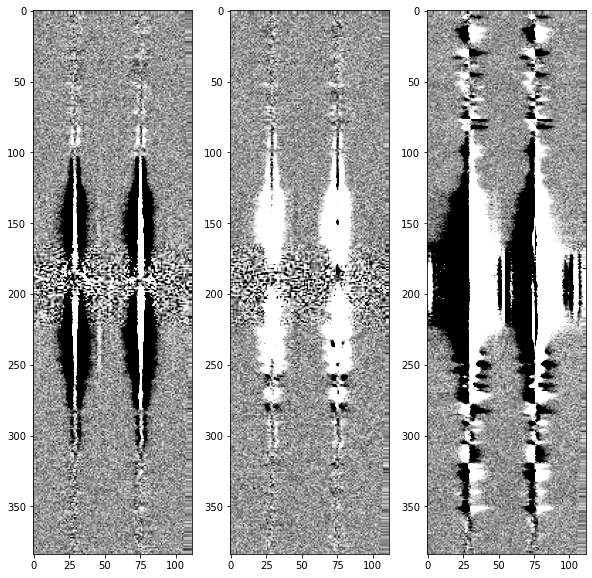

In [3]:
# Show that continuum polarization is removed from the regions that need it
fig,axs = plt.subplots(ncols=3,nrows=1)
fig.set_size_inches([10,10])

iZ = 180 # region from the middle of the sunspot

axs[0].imshow(data[iZ,:,:,1]/data[iZ,:,:,0], vmin=-0.01, vmax=0.01, cmap='Greys_r')
axs[1].imshow(data[iZ,:,:,2]/data[iZ,:,:,0], vmin=-0.01, vmax=0.01, cmap='Greys_r')
axs[2].imshow(data[iZ,:,:,3]/data[iZ,:,:,0], vmin=-0.01, vmax=0.01, cmap='Greys_r')

plt.show()

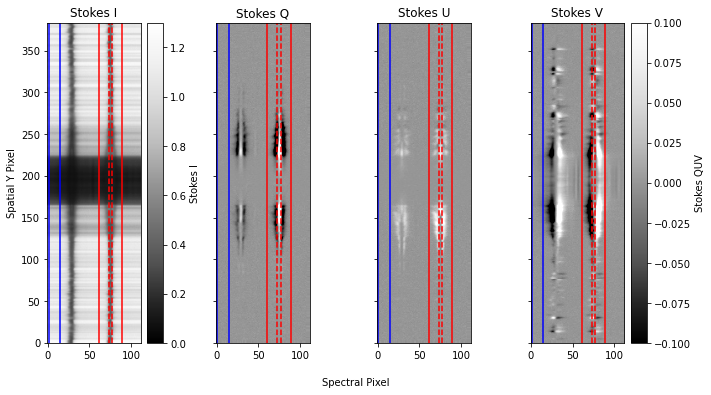

In [4]:
# Show the location of spectral regions selected
%matplotlib inline
fig,axs=plt.subplots(ncols=4, nrows=1, sharex=True, sharey=True)
fig.set_size_inches(10,5.5)
fig.supxlabel('Spectral Pixel', fontsize=10)

iZ=180

implot1=axs[0].imshow(data[iZ,:,:,0], vmin=0, vmax=1.3, origin='lower', cmap='Greys_r')
axs[0].set_title('Stokes I')
axs[0].set_ylabel('Spatial Y Pixel')
cb1=fig.colorbar(implot1, ax=axs[0], label='Stokes I')

axs[1].imshow(data[iZ,:,:,1], vmin=-0.1, vmax=0.1, origin='lower', cmap='Greys_r')
axs[1].set_title('Stokes Q')

axs[2].imshow(data[iZ,:,:,2], vmin=-0.1, vmax=0.1, origin='lower', cmap='Greys_r')
axs[2].set_title('Stokes U')

implot2=axs[3].imshow(data[iZ,:,:,3], vmin=-0.1, vmax=0.1, origin='lower', cmap='Greys_r')
axs[3].set_title('Stokes V')
cb2=fig.colorbar(implot2, ax=axs[3], label='Stokes QUV')

for iS in range(0,nS):
    #show the continuum region
    axs[iS].plot([c0,c0],[0,nY-1], 'b-')
    axs[iS].plot([c1,c1],[0,nY-1], 'b-')

    #show the line center
    #axs[iS].plot([l0,l0],[0,nY-1], 'r--')
    
    #show the line core
    axs[iS].plot([l0-dw1,l0-dw1],[0,nY-1], 'r--')
    axs[iS].plot([l0+dw1,l0+dw1],[0,nY-1], 'r--')
    
    #show the line wings
    axs[iS].plot([l0-dw2,l0-dw2],[0,nY-1], 'r-')
    axs[iS].plot([l0+dw2,l0+dw2],[0,nY-1], 'r-')
    
plt.tight_layout()
plt.show()

In [5]:
# Do selection of spatial areas
x0 = l0-dw2
x1 = l0+dw2

# Make the continuum intensity map
imap = np.median(data[:,:,c0:c1,0], axis=2)
imap = imap.transpose()

# Make the polarization fraction map
pmap = np.max( np.sqrt(np.sum(data[:,:,x0:x1,1:]**2, axis=3))/data[:,:,x0:x1,0], axis=2)
pmap = pmap.transpose()

# Apply thresholds to define different regions
isumbra = np.argwhere(imap < ithresh)
uyidx = isumbra[:,0]
uzidx = isumbra[:,1]

ispolar = np.argwhere(pmap > pthresh)
pyidx = ispolar[:,0]
pzidx = ispolar[:,1]

notpolar = np.argwhere(pmap < pthresh)
nyidx = notpolar[:,0]
nzidx = notpolar[:,1]

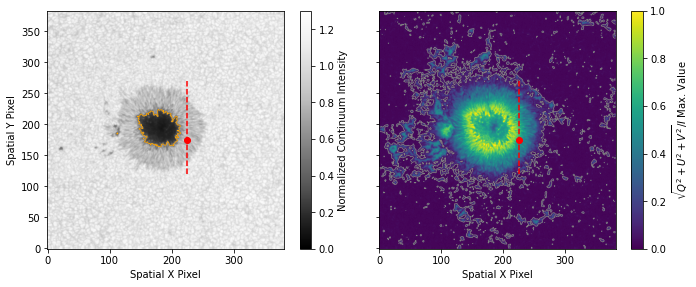

In [6]:
%matplotlib inline
fig,axs=plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True)
fig.set_size_inches(10,4)

iZ=225
iY=175
y0=120
y1=270

iplot=axs[0].imshow(imap, vmin=0.0, vmax=1.3, origin='lower', cmap='Greys_r')
axs[0].contour(imap, [ithresh], colors='orange', linewidths=0.75)
axs[0].set_xlabel('Spatial X Pixel')
axs[0].set_ylabel('Spatial Y Pixel')
icb=fig.colorbar(iplot, ax=axs[0], label='Normalized Continuum Intensity')

pplot=axs[1].imshow(pmap, vmin=0, vmax=1.0, origin='lower')
axs[1].contour(pmap, [pthresh], colors='gray', linewidths=0.75)
axs[1].set_xlabel('Spatial X Pixel')
pcb=fig.colorbar(pplot, ax=axs[1], label='$\sqrt{Q^2+U^2+V^2}/I$ Max. Value')

axs[0].plot([iZ,iZ], [y0,y1], '--r')
axs[0].plot([iZ], [iY], 'or')
axs[1].plot([iZ,iZ], [y0,y1], '--r')
axs[1].plot([iZ], [iY], 'or')

plt.tight_layout()
plt.show()

In [7]:
# These are the model and minimization functions as defined in the paper

# Functions for the diattenuation modeling
def polmodel1(D,theta,chi):
    dH = D*np.cos(chi)*np.sin(theta)
    d45 = D*np.sin(chi)*np.sin(theta)
    dR = D*np.cos(theta)
    A = np.sqrt(1. - dH**2 - d45**2 - dR**2)
    
    mat1 = np.array([
        [ 1., dH, d45, dR], 
        [ dH,  A,  0., 0.], 
        [d45, 0.,   A, 0.],
        [ dR, 0.,  0.,  A]], dtype='double')
    
    mat2 = np.array([
        [0.,     0.,     0.,     0.],
        [0.,  dH**2, d45*dH,  dH*dR],
        [0., d45*dH, d45**2, d45*dR],
        [0.,  dH*dR, d45*dR,  dR**2]], dtype='double')
    
    return( mat1 + (1-A)/D**2*mat2 )

def fitfunc1(param, stokesin):
    D = param[0]
    theta = param[1]
    chi = param[2]
    
    # Keep diattenuation value in range
    if D>=1:
        D=0.999999
        
    if D<=-1:
        D = -0.999999
        
    MM = polmodel1(D, theta, chi)
    iMM = np.linalg.inv(MM)

    out = minimize_for_model1(iMM,stokesin)

    return(out)

def minimize_for_model1(iMM,bs):
    # apply a mueller matrix (rotation) to a 2D stokes vector (slit_Y,wavelength_X,4)
    new_stokes = np.einsum('ij,abj->abi',iMM, np.squeeze(bs))
    
    # Minimization criteria
    out = np.abs(np.sum(new_stokes[:,:,0]*new_stokes[:,:,3],axis=1)) + \
          np.abs(np.sum(new_stokes[:,:,0]*new_stokes[:,:,2],axis=1)) + \
          np.abs(np.sum(new_stokes[:,:,0]*new_stokes[:,:,1],axis=1))

    # sum over spatial positions
    out = np.sum(out)
    
    return(out)


# Functions for the retarder modeling
def polmodel2(theta, delta):
    St = np.sin(theta)
    Ct = np.cos(theta)
    Sd = np.sin(delta)
    Cd = np.cos(delta)
 
    MM1 = np.array([
        [1.,  0., 0., 0.],
        [0.,  Ct, St, 0.],
        [0., -St, Ct, 0.],
        [0.,  0., 0., 1.]
    ], dtype='double')
    
    MM2 = np.array([
        [1., 0.,  0., 0.],
        [0., 1.,  0., 0.],
        [0., 0.,  Cd, Sd],
        [0., 0., -Sd, Cd]
    ], dtype='double')
    
    MM = np.einsum('ij,jk', MM1, MM2)
    return(MM)
    
def fitfunc2(fitangles, stokesin):
    theta = fitangles[0]
    delta = fitangles[1]
    
    MM = polmodel2(theta, delta)
    iMM = np.linalg.inv(MM)

    out = minimize_for_model2(iMM, stokesin)

    return(out)

def minimize_for_model2(iMM,bs):
    new_stokes = np.einsum('ij,abj->abi',iMM, np.squeeze(bs))
    
    # Minimization criteria
    out = np.sum(new_stokes[:,:,3],axis=1)**2 +\
          np.abs(np.sum(new_stokes[:,:,3]*new_stokes[:,:,2],axis=1)) +\
          np.abs(np.sum(new_stokes[:,:,3]*new_stokes[:,:,1],axis=1))
    
    # sum over spatial positions
    out = np.sum(out)
    
    return(out)

In [8]:
# Apply cross-talk Mueller matrix to the original data
data0 = np.einsum('ij,abcj->abci', MMsys, data)

# Choose initial guess parameters for the diattenuation minimization
D = 0.5
theta = 0.
chi = 0.
initial_guess = (D, theta, chi)
                 
# Use just the region with weak polarization
baddata = data0[nzidx,nyidx,:,:] #do selection for only strong polarization signals
result = minimize(fitfunc1, initial_guess, args=baddata)

# Apply correction for I<->QUV cross-talk
MM1a = polmodel1(result.x[0],result.x[1], result.x[2])
iMM1a = np.linalg.inv(MM1a)
data1a =  np.einsum('ij,abcj->abci', iMM1a, data0)

# Destreaking correction to data might happen here

# Choose an initial guess of those cross-talk parameters for the minimization algorithm
theta = 0.*np.pi/180.
delta = 0.*np.pi/180.
initial_guess = (theta,delta)

# Find the elliptical retardance parameters that minimize V*Q, V*U, and V*V
baddata = data1a[pzidx, pyidx,:,:]
result = minimize(fitfunc2, initial_guess, args=baddata)

# Apply correction for QU<->V cross-talk
MM2a = polmodel2(result.x[0],result.x[1])
iMM2a = np.linalg.inv(MM2a)
data2a =  np.einsum('ij,abcj->abci', iMM2a, data1a)

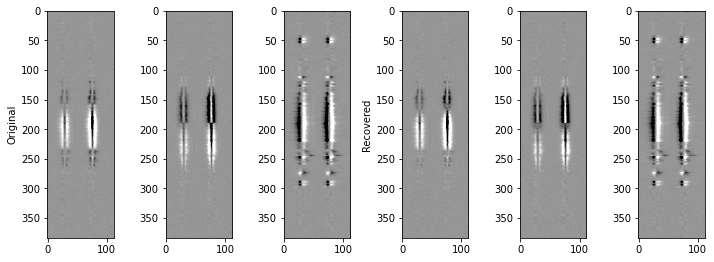

In [9]:
# Apply final sign correction to match original spectra
iMM3a = np.array( [[1., 0., 0., 0.],
                   [0., 1., 0., 0.],
                   [0., 0., 1., 0.],
                   [0., 0., 0., 1.]], dtype='double')
MM3a = np.linalg.inv(iMM3a)
data3a = np.einsum('ij,abcj->abci', iMM3a, data2a)

MMa=MM1a@MM2a@MM3a

# Show a quick plot to verify
fig,axs = plt.subplots(ncols=6)
fig.set_size_inches(10,5)

iZ = 225 # region from the middle of the sunspot

axs[0].imshow(data[iZ,:,:,1], vmin=-0.1, vmax=0.1, cmap='Greys_r')
axs[1].imshow(data[iZ,:,:,2], vmin=-0.1, vmax=0.1, cmap='Greys_r')
axs[2].imshow(data[iZ,:,:,3], vmin=-0.1, vmax=0.1, cmap='Greys_r')
axs[0].set_ylabel('Original')

axs[3].imshow(data3a[iZ,:,:,1], vmin=-0.1, vmax=0.1, cmap='Greys_r')
axs[4].imshow(data3a[iZ,:,:,2], vmin=-0.1, vmax=0.1, cmap='Greys_r')
axs[5].imshow(data3a[iZ,:,:,3], vmin=-0.1, vmax=0.1, cmap='Greys_r')
axs[3].set_ylabel('Recovered')

plt.tight_layout()
plt.show()

In [10]:
# Apply the Sanchez Almeida & Lites (1992)/Kuhn et al (1994) method to the dataset

# Determine the I->QUV coefficents using just the continuum region
e = np.mean(data0[:,:,c0:c1,1]/data0[:,:,c0:c1,0])
f = np.mean(data0[:,:,c0:c1,2]/data0[:,:,c0:c1,0])
g = np.mean(data0[:,:,c0:c1,3]/data0[:,:,c0:c1,0])

# Apply the I->QUV coefficents to correct the data
data1b = np.ndarray([nZ,nY,nX,nS])
data1b[:,:,:,1] = data0[:,:,:,1] - e*data0[:,:,:,0]
data1b[:,:,:,2] = data0[:,:,:,2] - f*data0[:,:,:,0]
data1b[:,:,:,3] = data0[:,:,:,3] - g*data0[:,:,:,0]


# Do a center of mass to find the line ceneter based on the net polarized profile
x0 = l0-dw2
x1 = l0+dw2

xarray = np.arange(0,nX)
xarray = xarray.reshape([1,1,nX])

xcen = np.sum( np.sqrt( np.sum(data1b[:,:,x0:x1,1:]**2, axis=3) ) * xarray[:,:,x0:x1], axis=2) / \
       np.sum( np.sqrt( np.sum(data1b[:,:,x0:x1,1:]**2, axis=3) ), axis=2)

# Shift all profiles to median center position
xcen0 = int(np.median(xcen))
xshift = xcen0-xcen

data1b_com = np.ndarray([nZ,nY,nX,nS])

for iZ in range(0,nZ):
    for iY in range(0,nY):
        data1b_com[iZ,iY,:,0]=shift(data1b[iZ,iY,:,0], xshift[iZ,iY], order=3, mode='nearest')
        data1b_com[iZ,iY,:,1]=shift(data1b[iZ,iY,:,1], xshift[iZ,iY], order=3, mode='nearest')
        data1b_com[iZ,iY,:,2]=shift(data1b[iZ,iY,:,2], xshift[iZ,iY], order=3, mode='nearest')
        data1b_com[iZ,iY,:,3]=shift(data1b[iZ,iY,:,3], xshift[iZ,iY], order=3, mode='nearest')
    
# Determine the Q,U->V parameters a,b through linear regression just from umbral profiles
x0 = l0-dw1
x1 = l0+dw1

qtmp = np.sum(data1b_com[uzidx,uyidx,x0:x1,1], axis=1)
utmp = np.sum(data1b_com[uzidx,uyidx,x0:x1,2], axis=1)
vtmp = np.sum(data1b_com[uzidx,uyidx,x0:x1,3], axis=1)

# Make a pandas dataframe to do the linear regression
df=pd.DataFrame({'SQ':qtmp, 'SU':utmp, 'SV':vtmp}, columns=['SQ', 'SU', 'SV'])
    
regr=linear_model.LinearRegression()
regr.fit(df[['SQ','SU']], df['SV'])

a = regr.coef_[0]
b = regr.coef_[1]

# Make a corrected Stokes V for the determination of V->Q,U
x0 = l0-dw2
x1 = l0+dw2

# Use all profiles with strong polarization signal
qtmp = data1b_com[pzidx,pyidx,x0:x1,1]
utmp = data1b_com[pzidx,pyidx,x0:x1,2]
vtmp = data1b_com[pzidx,pyidx,x0:x1,3] - a*qtmp - b*utmp

# Determine the V->QU parameters
c = np.nanmedian( np.nanmean(qtmp*vtmp, axis=1) / np.nanmean(vtmp**2, axis=1) )
d = np.nanmedian( np.nanmean(utmp*vtmp, axis=1) / np.nanmean(vtmp**2, axis=1) )


# Reconstruct Sanchez Almeida & Lites (1992) I->QUV cross talk matrix
iMM1b = np.array( [[1., 0., 0., 0.],
                   [-e, 1., 0., 0.],
                   [-f, 0., 1., 0.],
                   [-g, 0., 0., 1.]], dtype='double')
MM1b = np.linalg.inv(iMM1b)

# Reconstruct the Kuhn et al (1994) QU<->V cross talk matrix
iMM2b = np.array( [[1.,     0.,     0., 0.],
                   [0., 1.+a*c,    c*b, -c],
                   [0.,    a*d, 1.+b*d, -d],
                   [0.,     -a,     -b, 1.]], dtype='double')
MM2b = np.linalg.inv(iMM2b)

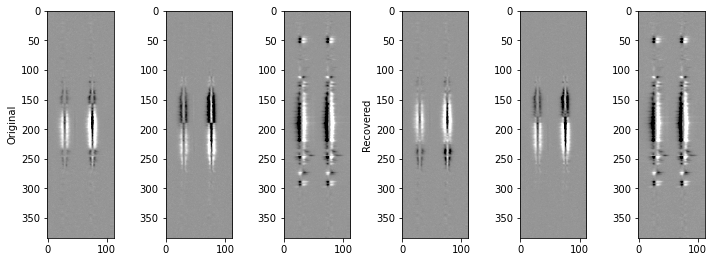

In [11]:
# Apply the final sign correction to match the original data
iMM3b = np.array( [[1., 0.,  0., 0.],
                   [0., 1.,  0., 0.],
                   [0., 0.,  1., 0.],
                   [0., 0.,  0., 1.]], dtype='double')
MM3b = np.linalg.inv(iMM3b)

MMb = MM1b@MM2b@MM3b
iMMb = iMM3b@iMM2b@iMM1b

#make reconstructed data
data3b = np.einsum('ij,abcj->abci', iMMb, data0)


# Show a quick plot to verify
fig,axs = plt.subplots(ncols=6)
fig.set_size_inches(10,5)

iZ = 225 # region from the middle of the sunspot

axs[0].imshow(data[iZ,:,:,1], vmin=-0.1, vmax=0.1, cmap='Greys_r')
axs[1].imshow(data[iZ,:,:,2], vmin=-0.1, vmax=0.1, cmap='Greys_r')
axs[2].imshow(data[iZ,:,:,3], vmin=-0.1, vmax=0.1, cmap='Greys_r')
axs[0].set_ylabel('Original')

axs[3].imshow(data3b[iZ,:,:,1], vmin=-0.1, vmax=0.1, cmap='Greys_r')
axs[4].imshow(data3b[iZ,:,:,2], vmin=-0.1, vmax=0.1, cmap='Greys_r')
axs[5].imshow(data3b[iZ,:,:,3], vmin=-0.1, vmax=0.1, cmap='Greys_r')
axs[3].set_ylabel('Recovered')

plt.tight_layout()
plt.show()

# Look at Results

In [12]:
#Try out the inequalities from Kostinski & Givens (1993) that test the physical realism of a Muller matrix
#define functions for each of the quantities
def KG1(MM):
    value = np.trace(MM.transpose() @ MM)
    return(value)

def KG2(MM):
    mag_m1 = np.sqrt(MM[0,1]**2 + MM[0,2]**2 + MM[0,3]**2)
    mag_m2 = np.sqrt(MM[1,0]**2 + MM[2,0]**2 + MM[3,0]**2)
    value = 4.*MM[0,0]**2 + 2.*(mag_m1**2-mag_m2**2)
    return(value)

def KG3(MM):
    m1hat = MM[0,1:] / np.sqrt( np.sum(MM[0,1:]**2) )
    a = MM[1:,1:]
    value = np.sum( (MM[1:,0] - a@m1hat)**2 )
    return(value)

def KG4(MM):
    mag_m1 = np.sqrt(MM[0,1]**2 + MM[0,2]**2 + MM[0,3]**2)
    value = (MM[0,0] - mag_m1)**2
    return(value)

print('Input Muller Matrix')
print( np.round(MMsys, decimals=3))
print(KG1(MMsys), '< or =', KG2(MMsys))
print(KG3(MMsys), '< or =', KG4(MMsys))

print('Recovered Muller Matrix, This Work')
print( np.round(MMa, decimals=3))
print(KG1(MMa), '< or =', KG2(MMa))
print(KG3(MMa), '< or =', KG4(MMa))
print('Residual Muller Matrix, This Work')
MMa_residual = np.linalg.inv(MMa) @ MMsys
print(np.round( MMa_residual, decimals=3))
tmp=np.array([np.arcsin(MMa_residual[1,2]), np.arcsin(-MMa_residual[2,1]),
              np.arccos(MMa_residual[1,1]), np.arccos(MMa_residual[2,2])])
phi=np.mean(tmp)
Sp=np.sin(phi)
Cp=np.cos(phi)
MM4a = np.array([
    [1.,  0., 0., 0.],
    [0.,  Cp, Sp, 0.],
    [0., -Sp, Cp, 0.],
    [0.,  0., 0., 1.]
], dtype='double')
iMM4a = np.linalg.inv(MM4a)
print('final geometric rotation angle', phi*180/np.pi)
print(np.round(MMa@MM4a, decimals=3))
print(np.round(np.linalg.inv(MMa@MM4a) @ MMsys, decimals=3))

print('Recovered Muller Matrix, Sanchez Almeida/Kuhn')
print( np.round(MMb, decimals=3))
print(KG1(MMb), '< or =', KG2(MMb))
print(KG3(MMb), '< or =', KG4(MMb))
print('Residual Muller Matrix, Sanchez Almeida/Kuhn')
MMb_residual = np.linalg.inv(MMb) @ MMsys
print(np.round( MMb_residual, decimals=3))
tmp=np.array([np.arcsin(MMb_residual[1,2]), -np.arcsin(MMb_residual[2,1]),
              -np.arccos(MMb_residual[1,1]), -np.arccos(MMb_residual[2,2])])
print(tmp)
phi=np.mean(tmp)
Sp=np.sin(phi)
Cp=np.cos(phi)
MM4b = np.array([
    [1.,  0., 0., 0.],
    [0.,  Cp, Sp, 0.],
    [0., -Sp, Cp, 0.],
    [0.,  0., 0., 1.]
], dtype='double')
iMM4b = np.linalg.inv(MM4b)
print('final geometric rotation angle', phi*180/np.pi)
print(np.round(MMb@MM4b, decimals=3))
print(np.round(np.linalg.inv(MMb@MM4b) @ MMsys, decimals=3))

Input Muller Matrix
[[ 1.     0.007  0.053 -0.02 ]
 [-0.033  0.728 -0.592  0.344]
 [ 0.047  0.674  0.704 -0.22 ]
 [ 0.002 -0.112  0.392  0.911]]
4.0 < or = 4.0
0.8893218839441065 < or = 0.8893218839441067
Recovered Muller Matrix, This Work
[[ 1.     0.022  0.049 -0.019]
 [-0.033  0.528 -0.776  0.342]
 [ 0.047  0.848  0.485 -0.213]
 [ 0.002  0.     0.402  0.914]]
4.0 < or = 4.0
0.8893731264651672 < or = 0.8893731264651672
Residual Muller Matrix, This Work
[[ 1.     0.     0.     0.   ]
 [ 0.     0.959  0.285 -0.005]
 [ 0.    -0.285  0.959 -0.006]
 [ 0.     0.003  0.007  1.   ]]
final geometric rotation angle 16.534963047739403
[[ 1.     0.007  0.053 -0.019]
 [-0.033  0.727 -0.594  0.342]
 [ 0.047  0.675  0.706 -0.213]
 [ 0.002 -0.114  0.386  0.914]]
[[ 1.     0.     0.     0.   ]
 [ 0.     1.    -0.    -0.003]
 [ 0.     0.     1.    -0.007]
 [ 0.     0.003  0.007  1.   ]]
Recovered Muller Matrix, Sanchez Almeida/Kuhn
[[ 1.     0.     0.     0.   ]
 [-0.033  1.     0.     0.314]
 [ 0.047

/var/folders/tk/4ztr44zd507_0fl_zvcjk8k00000gn/T/ipykernel_13349/1881087434.py:14: RuntimeWarning: invalid value encountered in true_divide
  m1hat = MM[0,1:] / np.sqrt( np.sum(MM[0,1:]**2) )


In [13]:
# Compare the total unsigned polarization signal between recovered 
# and original Stokes vectors
ptot_orig=np.sum( np.sqrt(np.sum(data[:,:,x0:x1,1:]**2, axis=3)) )
ptot_new=np.sum( np.sqrt(np.sum(data3a[:,:,x0:x1,1:]**2, axis=3)) )
ptot_kuhn=np.sum( np.sqrt(np.sum(data3b[:,:,x0:x1,1:]**2, axis=3)) )

print(ptot_new/ptot_orig)
print(ptot_kuhn/ptot_orig)

0.9999996835882994
1.0436984782758494


/var/folders/tk/4ztr44zd507_0fl_zvcjk8k00000gn/T/ipykernel_13349/2422565830.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


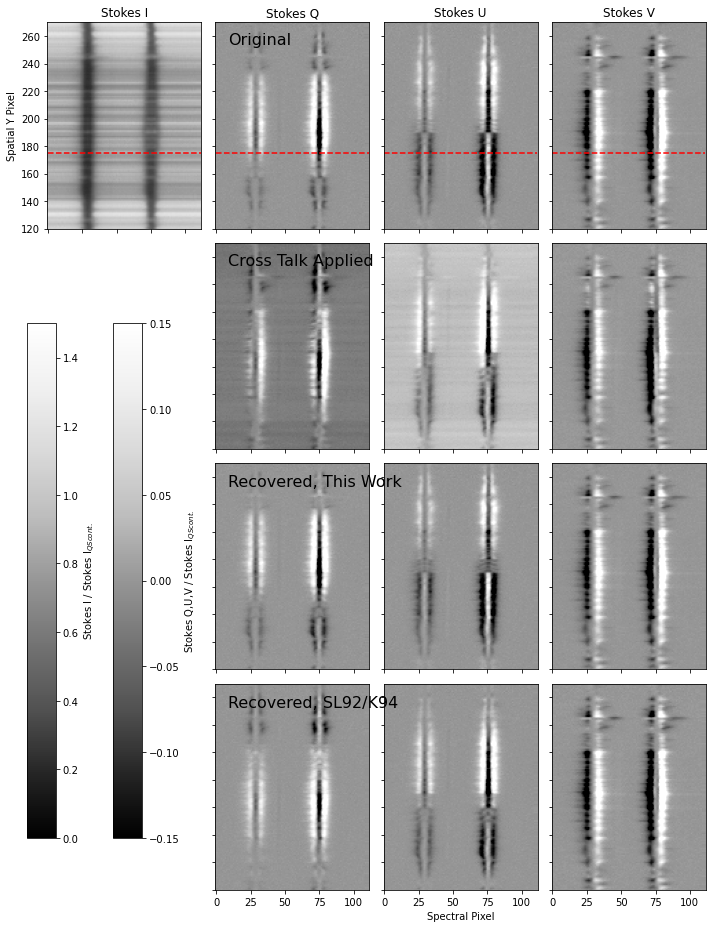

In [14]:
# Make plot showing the example spectra
%matplotlib inline
fig,axs=plt.subplots(ncols=4, nrows=4, sharex=True, sharey=True)
fig.set_size_inches(10,13)

iZ=225 #180
iY=175
y0=120
y1=270

axs[0,0].set_ylabel('Spatial Y Pixel')
axs[3,2].set_xlabel('Spectral Pixel')

axs[0,0].set_title('Stokes I')
axs[0,1].set_title('Stokes Q')
axs[0,2].set_title('Stokes U')
axs[0,3].set_title('Stokes V')

axs[0,0].set_ylim(y0,y1)

#axs[0,1].annotate('Original', [10,y1-20], fontsize=16, zorder=100)
iplot=axs[0,0].imshow(data[iZ,:,:,0], vmin=0, vmax=1.5, origin='lower', cmap='Greys_r')
pplot=axs[0,1].imshow(data[iZ,:,:,1], vmin=-0.15, vmax=0.15, origin='lower', cmap='Greys_r')
axs[0,2].imshow(data[iZ,:,:,2], vmin=-0.15, vmax=0.15, origin='lower', cmap='Greys_r')
axs[0,3].imshow(data[iZ,:,:,3], vmin=-0.15, vmax=0.15, origin='lower', cmap='Greys_r')

axs[0,0].plot([0,nX-1],[iY,iY], '--r')
axs[0,1].plot([0,nX-1],[iY,iY], '--r')
axs[0,2].plot([0,nX-1],[iY,iY], '--r')
axs[0,3].plot([0,nX-1],[iY,iY], '--r')

#axs[1,0].imshow(data0[iZ,:,:,0], vmin=0, vmax=1.5, origin='lower', cmap='Greys_r')
axs[1,0].remove()
axs[1,1].imshow(data0[iZ,:,:,1], vmin=-0.15, vmax=0.15, origin='lower', cmap='Greys_r')
axs[1,2].imshow(data0[iZ,:,:,2], vmin=-0.15, vmax=0.15, origin='lower', cmap='Greys_r')
axs[1,3].imshow(data0[iZ,:,:,3], vmin=-0.15, vmax=0.15, origin='lower', cmap='Greys_r')

#axs[2,0].imshow(data1a[iZ,:,:,0], vmin=0, vmax=1.5, origin='lower', cmap='Greys_r')
axs[2,0].remove()
axs[2,1].imshow(data3a[iZ,:,:,1], vmin=-0.15, vmax=0.15, origin='lower', cmap='Greys_r')
axs[2,2].imshow(data3a[iZ,:,:,2], vmin=-0.15, vmax=0.15, origin='lower', cmap='Greys_r')
axs[2,3].imshow(data3a[iZ,:,:,3], vmin=-0.15, vmax=0.15, origin='lower', cmap='Greys_r')

#axs[3,0].imshow(data2b[iZ,:,:,0], vmin=0, vmax=1.5, origin='lower', cmap='Greys_r')
axs[3,0].remove()
axs[3,1].imshow(data3b[iZ,:,:,1], vmin=-0.15, vmax=0.15, origin='lower', cmap='Greys_r')
axs[3,2].imshow(data3b[iZ,:,:,2], vmin=-0.15, vmax=0.15, origin='lower', cmap='Greys_r')
axs[3,3].imshow(data3b[iZ,:,:,3], vmin=-0.15, vmax=0.15, origin='lower', cmap='Greys_r')

icbax = plt.axes([0.04, 0.1, 0.04, 0.55])
icb=fig.colorbar(iplot, cax=icbax, label='Stokes I / Stokes I$_{QS cont.}$')

pcbax = plt.axes([0.16, 0.1, 0.04, 0.55])
pcb=fig.colorbar(pplot, cax=pcbax, label='Stokes Q,U,V / Stokes I$_{QS cont.}$')

fig.text(0.32, 0.948, 'Original', fontsize=16)
fig.text(0.32, 0.712, 'Cross Talk Applied', fontsize=16)
fig.text(0.32, 0.476, 'Recovered, This Work', fontsize=16)
fig.text(0.32, 0.240, 'Recovered, SL92/K94', fontsize=16)

plt.tight_layout()
plt.show()

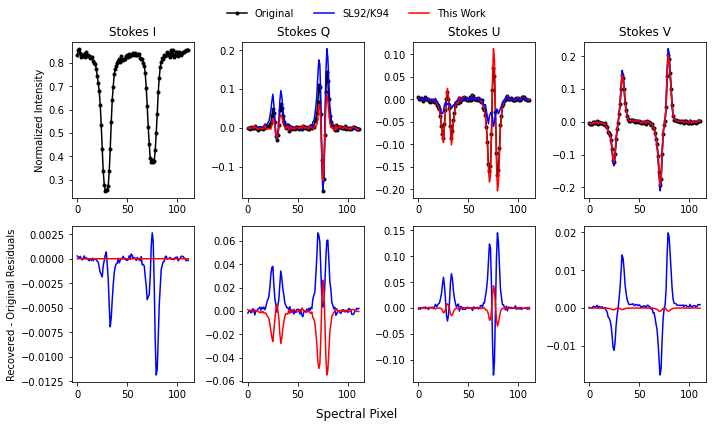

In [15]:
# make example profile plot
iZ=225 #180
iY=175

%matplotlib inline

fig,axs=plt.subplots(ncols=4, nrows=2)
fig.set_size_inches(10,6)
fig.supxlabel('Spectral Pixel', x=0.5, y=0.03, fontsize=12)

axs[0,0].plot(data[iZ,iY,:,0], '.-k')
axs[0,0].set_title('Stokes I')
axs[0,0].set_ylabel('Normalized Intensity')
    
axs[0,1].plot(data[iZ,iY,:,1], '.-k', label='Original')
axs[0,1].plot(data3b[iZ,iY,:,1], 'b', label='SL92/K94')
axs[0,1].plot(data3a[iZ,iY,:,1], 'r', label='This Work')
axs[0,1].set_title('Stokes Q')
                
axs[0,2].plot(data[iZ,iY,:,2], '.-k')
axs[0,2].plot(data3a[iZ,iY,:,2], 'r')
axs[0,2].plot(data3b[iZ,iY,:,2], 'b')
axs[0,2].set_title('Stokes U')

axs[0,3].plot(data[iZ,iY,:,3], '.-k')
axs[0,3].plot(data3b[iZ,iY,:,3], 'b')
axs[0,3].plot(data3a[iZ,iY,:,3], 'r')
axs[0,3].set_title('Stokes V')

#axs[1,0].remove()
axs[1,0].plot(data3b[iZ,iY,:,0]-data[iZ,iY,:,0], 'b')
axs[1,0].plot(data3a[iZ,iY,:,0]-data[iZ,iY,:,0], 'r')
axs[1,0].set_ylabel('Recovered - Original Residuals')

axs[1,1].plot(data3b[iZ,iY,:,1]-data[iZ,iY,:,1], 'b')
axs[1,1].plot(data3a[iZ,iY,:,1]-data[iZ,iY,:,1], 'r')

axs[1,2].plot(data3b[iZ,iY,:,2]-data[iZ,iY,:,2], 'b')
axs[1,2].plot(data3a[iZ,iY,:,2]-data[iZ,iY,:,2], 'r')

axs[1,3].plot(data3b[iZ,iY,:,3]-data[iZ,iY,:,3], 'b')
axs[1,3].plot(data3a[iZ,iY,:,3]-data[iZ,iY,:,3], 'r')

legend = fig.legend(loc='upper center', frameon=False, ncol=3)#, bbox_to_anchor=(0.125, 0.3))

plt.tight_layout(rect=[0.0,0.0,1.0,0.97])
plt.show()

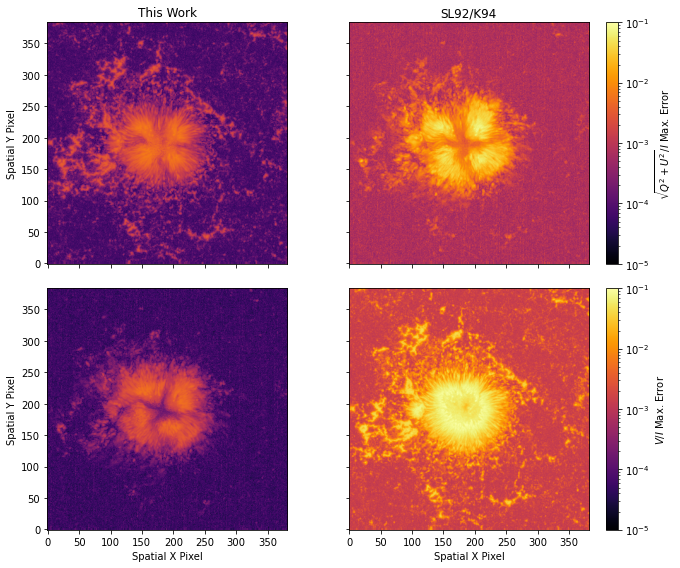

In [16]:
# Show a map of the max error in the net Stokes V polarization
errQUa = np.max( np.abs(np.sqrt(data3a[:,:,x0:x1,1]**2 + data3a[:,:,x0:x1,2]**2) -
                        np.sqrt(data[:,:,x0:x1,1]**2 + data[:,:,x0:x1,2]**2)) / data[:,:,x0:x1,0], axis=2)
errQUa = errQUa.transpose()

errVa = np.max( (np.abs(data3a[:,:,x0:x1,3]) - np.abs(data[:,:,x0:x1,3])) / data[:,:,x0:x1,0], axis=2)
errVa = errVa.transpose()

errQUb = np.max( np.abs(np.sqrt(data3b[:,:,x0:x1,1]**2 + data3b[:,:,x0:x1,2]**2) -
                        np.sqrt(data[:,:,x0:x1,1]**2 + data[:,:,x0:x1,2]**2)) / data[:,:,x0:x1,0], axis=2)
errQUb = errQUb.transpose()

errVb = np.max( (np.abs(data3b[:,:,x0:x1,3]) - np.abs(data[:,:,x0:x1,3])) / data[:,:,x0:x1,0], axis=2)
errVb = errVb.transpose()

%matplotlib inline
fig,axs=plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
fig.set_size_inches(10,8)

cmap='inferno'
norm = colors.LogNorm(0.00001, 0.1, clip='True')

plotQUa=axs[0,0].imshow(errQUa, origin='lower', norm=norm, cmap=cmap)
axs[0,0].set_ylabel('Spatial Y Pixel')
axs[0,0].set_title('This Work')

plotQUb=axs[0,1].imshow(errQUb, origin='lower', norm=norm, cmap=cmap)
axs[0,1].set_title('SL92/K94')
cbarQUb=fig.colorbar(plotQUb, ax=axs[0,1], label='$\sqrt{Q^2+U^2}/I$ Max. Error')

plotVa=axs[1,0].imshow(errVa, origin='lower', norm=norm, cmap=cmap)
axs[1,0].set_xlabel('Spatial X Pixel')
axs[1,0].set_ylabel('Spatial Y Pixel')

plotVb=axs[1,1].imshow(errVb, origin='lower', norm=norm, cmap=cmap)
axs[1,1].set_xlabel('Spatial X Pixel')
cbarVb=fig.colorbar(plotVb, ax=axs[1,1], label='$V/I$ Max. Error')

plt.tight_layout()
plt.show()